In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import trajectory as trj

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

file read
date selected


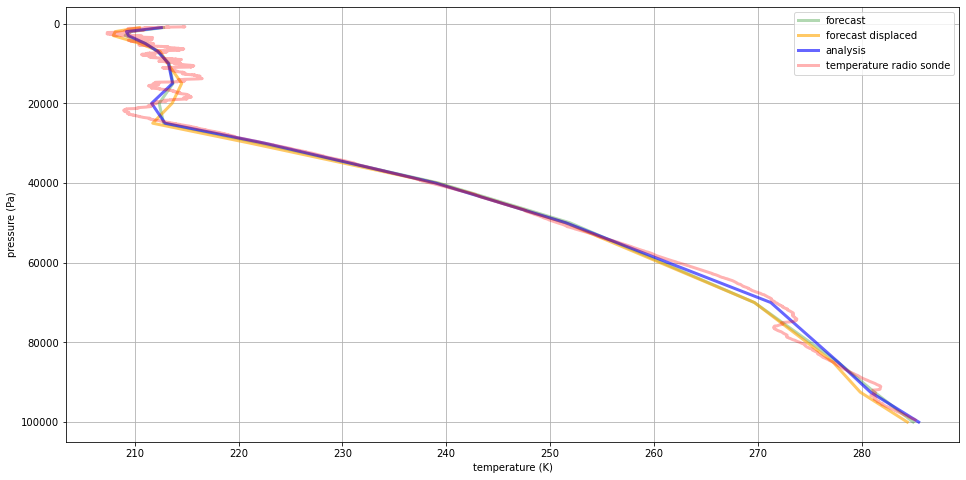

In [8]:
stat = '11035'
for iday in [-1000]:
    statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
    df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
    print('file read')
    day = np.unique(df.date_time)[iday]
    year = day.astype('datetime64[Y]').astype(int) + 1970
    month = day.astype('datetime64[M]').astype(int) % 12 + 1
    days = day - day.astype('datetime64[M]') + 1
    
    test = df[df.date_time == day]
    print('date selected')

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns='observed_variable')

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns='observed_variable')

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    search_lat = input_data.latitude.iloc[0]
    search_lon = input_data.longitude.iloc[0]
    search_time = input_data.date_time.iloc[0]

    files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(month)+'*.130.nc')
    for i in files:
        ds_fc = xr.load_dataset(i)
        ds_fc_time = ds_fc.interp(time=search_time, method='nearest')
        ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
        df_fc_loc = ds_fc_loc.to_dataframe()

        t_list = []
        for i in df_fc_loc.index:
            step = find_nearest(input_data.z_coordinate, i)
            input_data_step = input_data[input_data.z_coordinate == step]
            station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
        #     print(station_lat)
            station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]

            ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[station_lon], method="linear")
        #     print('selected lat: ', float(ds_now.latitude))
            t = ds_now.t.sel(level = i)
            t_list.append(float(t))

    files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(month)+'*.130.nc')
    for i in files:
        ds_an = xr.load_dataset(i)
        ds_an_time = ds_an.interp(time=search_time, method='nearest')
        ds_an_loc = ds_an_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
        df_an_loc = ds_an_loc.to_dataframe()


    fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    ax1.plot(df_fc_loc.t, np.array(df_fc_loc.index)*100, color = 'green', alpha = 0.3, label='forecast') #base tempterature')
    ax1.plot(np.array(t_list), np.array(df_fc_loc.index)*100, color = 'orange', alpha = 0.6, label='forecast displaced') #displaced temperature')
    ax1.plot(df_an_loc.t, np.array(df_an_loc.index)*100, color = 'blue', alpha = 0.6, label='analysis') #displaced temperature')
    ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('temperature (K)')
    ax1.tick_params(axis='y')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.legend()
    ax1.grid()


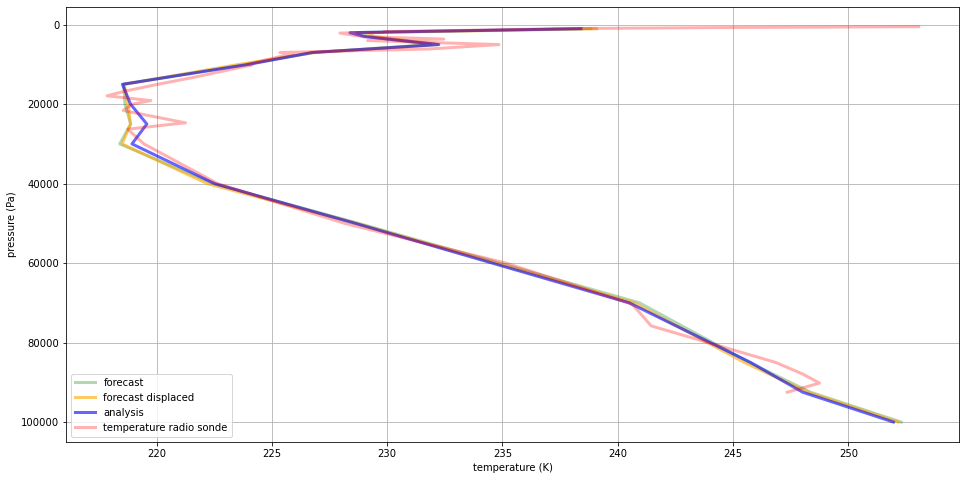

In [16]:
stat = '50527'
date_time = '2020-12-30 23:15:27'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

# test1 = [0] + list(input_data.calc_lond[:-1])
# test2 = [0] + list(input_data.calc_latd[:-1])
# input_data['prev_calc_lond']= test1
# input_data['prev_calc_latd']= test2

# input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
# input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


# input_data = input_data.dropna()

# with open('model_dt_no_dec_reduced_prev_new.p', "rb") as input_file:
#     model = pickle.load(input_file)
    
# out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

# ml_latd, ml_lond = out.transpose()
# input_data['ml_latd'] = ml_latd
# input_data['ml_lond'] = ml_lond

# input_data = input_data.reset_index()


search_lat = input_data.latitude.iloc[0]
search_lon = input_data.longitude.iloc[0]
search_time = input_data.date_time.iloc[0]

files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012*.130.nc')
for i in files:
    ds_fc = xr.load_dataset(i)
    ds_fc_time = ds_fc.interp(time=search_time, method='nearest')
    ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
    df_fc_loc = ds_fc_loc.to_dataframe()

    t_list = []
    for i in df_fc_loc.index:
        step = find_nearest(input_data.z_coordinate, i)
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
    #     print(station_lat)
        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]

        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[station_lon], method="linear")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t.sel(level = i)
        t_list.append(float(t))

# todo: displace

files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.202012*.130.nc')
for i in files:
    ds_an = xr.load_dataset(i)
    ds_an_time = ds_an.interp(time=search_time, method='nearest')
    ds_an_loc = ds_an_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
    df_an_loc = ds_an_loc.to_dataframe()
    


# ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
# ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")

# igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
# f = open(igrib)
# print(f)
# msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
# print(msgid)
# pv = codes_get_array(msgid,'pv')

# lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
# sp = np.exp(lnsp)

# pv = np.array(pv)
# a = pv[:int(len(pv)/2)]
# b = pv[int(len(pv)/2):]

# p_half = a + b * sp
# base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

# t_list = []
# for i in range(len(p_half[:-1])):
#     step = find_nearest(input_data.z_coordinate, p_half[i])
#     input_data_step = input_data[input_data.z_coordinate == step]
#     station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
# #     print(station_lat)
#     station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

#     ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
# #     print('selected lat: ', float(ds_now.latitude))
#     t = ds_now.t
#     t_list.append(np.array(t)[i][0][0])
# print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
# print(stat)
# print(date_time)

fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(df_fc_loc.t, np.array(df_fc_loc.index)*100, color = 'green', alpha = 0.3, label='forecast') #base tempterature')
ax1.plot(np.array(t_list), np.array(df_fc_loc.index)*100, color = 'orange', alpha = 0.6, label='forecast displaced') #displaced temperature')
ax1.plot(df_an_loc.t, np.array(df_an_loc.index)*100, color = 'blue', alpha = 0.6, label='analysis') #displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

In [13]:
t_list

[239.07030745757183,
 229.19050353182183,
 229.41470390401815,
 232.18664456468952,
 226.85890728295894,
 223.55826097601812,
 218.59319584681265,
 218.75109597905399,
 218.8684982301555,
 218.50079945488793,
 222.19445343759133,
 228.6767811630232,
 240.70491369283837,
 245.4875031081801,
 248.25646288738366,
 252.15643349724152]

In [11]:
ds_fc_loc

<xarray.Dataset>
Dimensions:    (level: 16)
Coordinates:
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
    time       datetime64[ns] 2020-12-30T23:15:27
    latitude   float32 49.25
    longitude  float32 119.7
Data variables:
    t          (level) float32 238.8 228.7 229.2 231.9 ... 245.7 248.4 252.3

In [5]:
input_data

,latitude,longitude,temperature,z_coordinate,date_time,u,v,z,calc_latd,calc_lond,prev_calc_lond,prev_calc_latd,lat_diff,lon_diff
38,49.25,119.699997,247.350006,92500.0,2020-12-30 23:15:27,3.914350,-5.803263,654.077560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37,49.25,119.699997,248.750000,90200.0,2020-12-30 23:15:27,0.627808,-8.978076,836.896629,-0.217116,0.105312,0.000000,0.000000,-0.217116,0.105312
36,49.25,119.699997,248.050003,88000.0,2020-12-30 23:15:27,0.000000,-9.000000,1016.435856,-0.389816,0.188839,0.105312,-0.217116,-0.172700,0.083527
35,49.25,119.699997,246.850006,85000.0,2020-12-30 23:15:27,1.929461,-6.728832,1267.669080,-0.419296,0.203903,0.188839,-0.389816,-0.029480,0.015064
34,49.25,119.699997,241.449997,75800.0,2020-12-30 23:15:27,8.528768,-9.811225,2086.297132,-0.499295,0.265854,0.203903,-0.419296,-0.079998,0.061951
33,49.25,119.699997,240.649994,70500.0,2020-12-30 23:15:27,8.134733,-18.270908,2597.743056,-0.516336,0.290341,0.265854,-0.499295,-0.017042,0.024488
32,49.25,119.699997,240.449997,70000.0,2020-12-30 23:15:27,8.134733,-18.270908,2647.858430,-0.524420,0.308246,0.290341,-0.516336,-0.008084,0.017905
31,49.25,119.699997,235.149994,60000.0,2020-12-30 23:15:27,10.665812,-19.241634,3720.810140,-0.524614,0.310066,0.308246,-0.524420,-0.000194,0.001819
30,49.25,119.699997,228.149994,50000.0,2020-12-30 23:15:27,17.633558,-24.270510,4956.979108,-0.523839,0.316464,0.310066,-0.524614,0.000775,0.006398
29,49.25,119.699997,222.649994,40000.0,2020-12-30 23:15:27,21.160269,-29.124611,6429.144547,-0.513281,0.365278,0.316464,-0.523839,0.010558,0.048814


In [21]:
search_lat = 49.25
search_lon = 119.699997
search_time = '2020-12-30T00:00:00'
files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.202012*.130.nc')
for i in files:
    ds_an = xr.load_dataset(i)
    ds_an_time = ds_an.sel(time=search_time)
    ds_an_loc = ds_an_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
    display(ds_an_loc)
    
files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012*.130.nc')
for i in files:
    ds_fc = xr.load_dataset(i)
    ds_fc_time = ds_fc.sel(time=search_time)
    ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
    display(ds_fc_loc)


<xarray.Dataset>
Dimensions:    (level: 16)
Coordinates:
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
    time       datetime64[ns] 2020-12-30
    latitude   float64 49.25
    longitude  float64 119.7
Data variables:
    t          (level) float64 236.9 230.8 231.3 233.3 ... 247.5 249.2 252.9

<xarray.Dataset>
Dimensions:    (level: 16)
Coordinates:
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
    time       datetime64[ns] 2020-12-30
    latitude   float64 49.25
    longitude  float64 119.7
Data variables:
    t          (level) float64 237.3 230.8 231.2 233.1 ... 247.8 249.5 253.1

<xarray.Dataset>
Dimensions:    (level: 16)
Coordinates:
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
    time       datetime64[ns] 2020-12-30
    latitude   float64 49.25
    longitude  float64 119.7
Data variables:
    t          (level) float64 236.9 230.8 231.3 233.3 ... 247.5 249.2 252.9

In [ ]:
ds.interp(time='2020-12-01T00:00:00')

In [15]:
ds.time

<xarray.DataArray 'time' (time: 124)>
array(['2020-12-01T00:00:00.000000000', '2020-12-01T06:00:00.000000000',
       '2020-12-01T12:00:00.000000000', '2020-12-01T18:00:00.000000000',
       '2020-12-02T00:00:00.000000000', '2020-12-02T06:00:00.000000000',
       '2020-12-02T12:00:00.000000000', '2020-12-02T18:00:00.000000000',
       '2020-12-03T00:00:00.000000000', '2020-12-03T06:00:00.000000000',
       '2020-12-03T12:00:00.000000000', '2020-12-03T18:00:00.000000000',
       '2020-12-04T00:00:00.000000000', '2020-12-04T06:00:00.000000000',
       '2020-12-04T12:00:00.000000000', '2020-12-04T18:00:00.000000000',
       '2020-12-05T00:00:00.000000000', '2020-12-05T06:00:00.000000000',
       '2020-12-05T12:00:00.000000000', '2020-12-05T18:00:00.000000000',
       '2020-12-06T00:00:00.000000000', '2020-12-06T06:00:00.000000000',
       '2020-12-06T12:00:00.000000000', '2020-12-06T18:00:00.000000000',
       '2020-12-07T00:00:00.000000000', '2020-12-07T06:00:00.000000000',
       '2020-12-07T12:00:00.000000000', '2020-12-07T18:00:00.000000000',
       '2020-12-08T00:00:00.000000000', '2020-12-08T06:00:00.000000000',
       '2020-12-08T12:00:00.000000000', '2020-12-08T18:00:00.000000000',
       '2020-12-09T00:00:00.000000000', '2020-12-09T06:00:00.000000000',
       '2020-12-09T12:00:00.000000000', '2020-12-09T18:00:00.000000000',
       '2020-12-10T00:00:00.000000000', '2020-12-10T06:00:00.000000000',
       '2020-12-10T12:00:00.000000000', '2020-12-10T18:00:00.000000000',
       '2020-12-11T00:00:00.000000000', '2020-12-11T06:00:00.000000000',
       '2020-12-11T12:00:00.000000000', '2020-12-11T18:00:00.000000000',
       '2020-12-12T00:00:00.000000000', '2020-12-12T06:00:00.000000000',
       '2020-12-12T12:00:00.000000000', '2020-12-12T18:00:00.000000000',
       '2020-12-13T00:00:00.000000000', '2020-12-13T06:00:00.000000000',
       '2020-12-13T12:00:00.000000000', '2020-12-13T18:00:00.000000000',
       '2020-12-14T00:00:00.000000000', '2020-12-14T06:00:00.000000000',
       '2020-12-14T12:00:00.000000000', '2020-12-14T18:00:00.000000000',
       '2020-12-15T00:00:00.000000000', '2020-12-15T06:00:00.000000000',
       '2020-12-15T12:00:00.000000000', '2020-12-15T18:00:00.000000000',
       '2020-12-16T00:00:00.000000000', '2020-12-16T06:00:00.000000000',
       '2020-12-16T12:00:00.000000000', '2020-12-16T18:00:00.000000000',
       '2020-12-17T00:00:00.000000000', '2020-12-17T06:00:00.000000000',
       '2020-12-17T12:00:00.000000000', '2020-12-17T18:00:00.000000000',
       '2020-12-18T00:00:00.000000000', '2020-12-18T06:00:00.000000000',
       '2020-12-18T12:00:00.000000000', '2020-12-18T18:00:00.000000000',
       '2020-12-19T00:00:00.000000000', '2020-12-19T06:00:00.000000000',
       '2020-12-19T12:00:00.000000000', '2020-12-19T18:00:00.000000000',
       '2020-12-20T00:00:00.000000000', '2020-12-20T06:00:00.000000000',
       '2020-12-20T12:00:00.000000000', '2020-12-20T18:00:00.000000000',
       '2020-12-21T00:00:00.000000000', '2020-12-21T06:00:00.000000000',
       '2020-12-21T12:00:00.000000000', '2020-12-21T18:00:00.000000000',
       '2020-12-22T00:00:00.000000000', '2020-12-22T06:00:00.000000000',
       '2020-12-22T12:00:00.000000000', '2020-12-22T18:00:00.000000000',
       '2020-12-23T00:00:00.000000000', '2020-12-23T06:00:00.000000000',
       '2020-12-23T12:00:00.000000000', '2020-12-23T18:00:00.000000000',
       '2020-12-24T00:00:00.000000000', '2020-12-24T06:00:00.000000000',
       '2020-12-24T12:00:00.000000000', '2020-12-24T18:00:00.000000000',
       '2020-12-25T00:00:00.000000000', '2020-12-25T06:00:00.000000000',
       '2020-12-25T12:00:00.000000000', '2020-12-25T18:00:00.000000000',
       '2020-12-26T00:00:00.000000000', '2020-12-26T06:00:00.000000000',
       '2020-12-26T12:00:00.000000000', '2020-12-26T18:00:00.000000000',
       '2020-12-27T00:00:00.000000000', '2020-12-27T06:00:00.000000000',
       '2020-12-27T12:00:00.000000000', '2020-12-27T18:00:00.000000000',
       '2020-12-28T0

## files
### 130 -  t
### 131 -  u
### 132 -  v
### 133 -  q
### 129 -  z

In [13]:
files

['/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012.130.nc',
 '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012.131.nc',
 '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012.132.nc',
 '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012.133.nc',
 '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.202012.129.nc']

In [8]:
ds.time

<xarray.DataArray 'time' (time: 248)>
array(['1974-03-01T03:00:00.000000000', '1974-03-01T06:00:00.000000000',
       '1974-03-01T09:00:00.000000000', ..., '1974-03-31T18:00:00.000000000',
       '1974-03-31T21:00:00.000000000', '1974-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1974-03-01T03:00:00 ... 1974-04-01
Attributes:
    long_name:  time

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179446801312
lat:  48.24895 lon:  16.35718
11035
2020-12-30 23:31:43


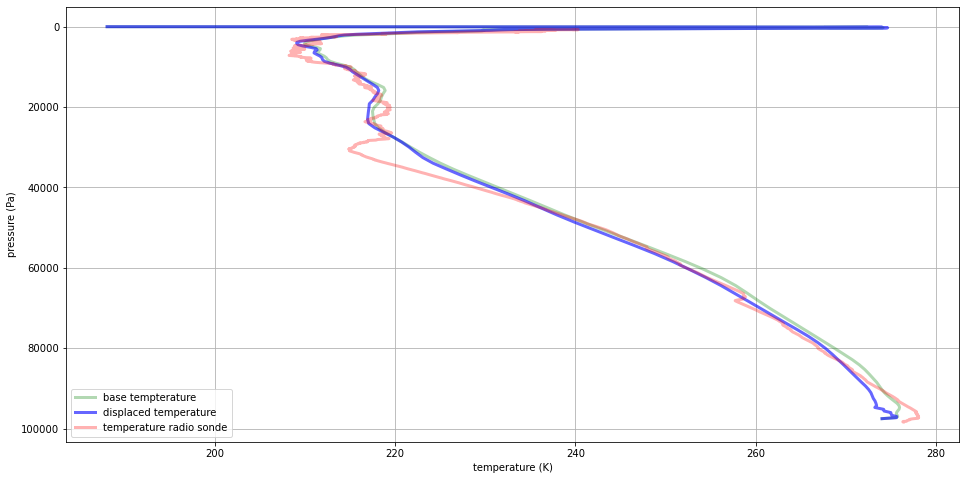

In [42]:
stat = '11035'
date_time = '2020-12-30 23:31:43'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179444069856
lat:  52.2093 lon:  14.12041
10393
2020-12-30 22:45:14


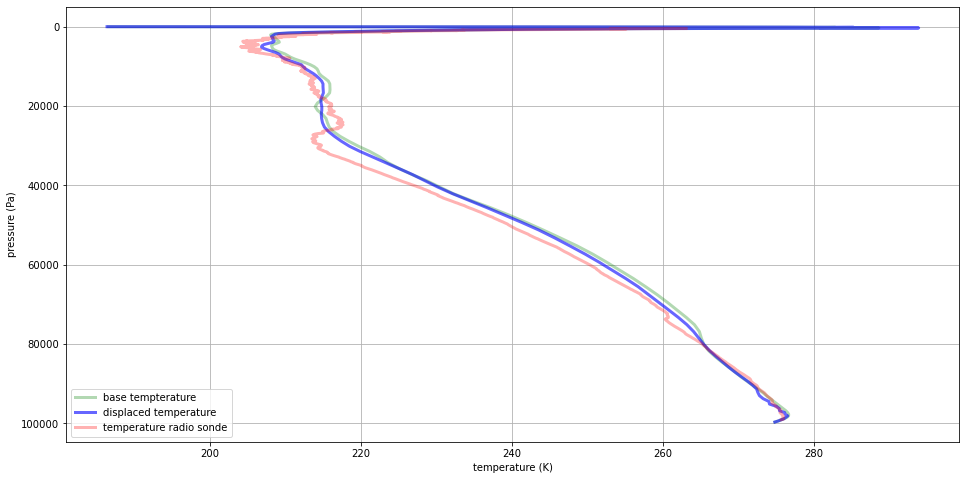

In [45]:
stat = '10393'
date_time = '2020-12-30 22:45:14'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179331665552
lat:  35.18 lon:  -97.44
72357
2020-12-31 00:00:00


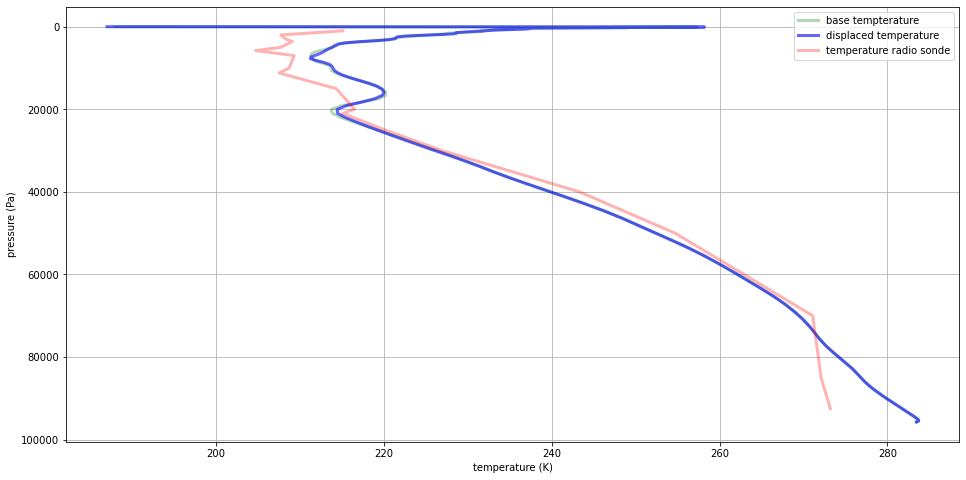

In [48]:
stat = '72357'
date_time = '2020-12-31 00:00:00'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()